In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import validation_curve, cross_val_score, learning_curve, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.svm import SVC
import warnings
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import ShuffleSplit


warnings.filterwarnings("ignore", category=FutureWarning)

# Coding Challenge
## Objective: improve performance
### Benchmark: https://triamus.github.io/project/lending-club-loan-data-in-r/#loan-amount-and-income

Some steps with preprocessing data was skipped, due to time constraint. The project is mainly supposed to show the improvement of the performance

# 1. First Steps

<li> Load Data 
<li> Use algorithm/ techinques to intelligently remove rest of the features

## Load Data

In [2]:
dat = np.load("data.npz",allow_pickle=True)
values = dat["arr_0"]
header = dat["arr_1"]
dt = pd.DataFrame(values,columns = header)

In [ ]:
dt = dt.replace([np.inf, -np.inf], np.nan).dropna()


# Feature Selection 

Problem of using all variables? Overfitting. Instead of handpicking variables, I'll try to use an algorithm to pick "right" features.
<br>
Options:
<li> Forward Selection
<li> Backward Selection
<li> Mutual Information Classification
<br>
Due to computing capacity and a sizable dataset, I'll use Mutual Information Classification to pick up first 30 and then Forward Selection to get 10 "best" features. In that way I will skip features that are correlated to each other.

## Mutual Information Classification

Given variables $X$ and $Y$, Mutual information (MI) measures the information that $X$ and $Y$ share. We will first calculate MI for each variable and pick up "top" 40 features.

NOTE: On my computer this section run for over 2 hours. I uploaded parameters that can be loaded directly. To save time proceed to next section to load parameters.

In [7]:
X = dt.drop("loan_status", axis=1)
y = dt["loan_status"]

In [ ]:
# If paramteters exist, load. Else, mutual information.
mutual_info = mutual_info_classif(X, y)
mutual_info

In [ ]:
mi_series = pd.Series(mutual_info)
mi_series.index = X.columns
mi_series.sort_values(ascending=False)

In [ ]:
mi_series.sort_values(ascending=False).plot.bar(figsize=(20,8))
plt.show()

In [ ]:
# If saved parameters exist, load. Else, run function for best features 
k_best_features = SelectKBest(mutual_info_classif, k=30).fit(x_train, y_train)

In [ ]:
print('Selected top 30 features: {}'.format(x_train.columns[k_best_features.get_support()]))

In [ ]:
columns_mutual_information = x_train.columns[k_best_features.get_support()]

In [ ]:
X = X[columns_mutual_information]

# Using Left Features Use Forward Selection to pick up 10 variables

I will use a Forward Looking Algorithm using a simple logistic regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


X_forward = X_train[columns_mutual_information]
X_forward_test = X_test[columns_mutual_information]



sfs1 = SFS(logisticRegr,
           k_features=12,
           forward=True,
           floating=False,
           verbose=2,
           scoring='recall',
           cv=5,
           n_jobs=-1)

mu_col = sfs1.fit(X_forward_test, y_test)

In [ ]:
columns_forward = list(sfs1.subsets_[12]['feature_names'])

In [ ]:
columns_forward

In [ ]:
X = X[columns_forward]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)



In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)


# Part 6: Try with new variable set
First, I will use the new parameters with a simple logisti regression, then I will experiement around with SVM. Finally, the plan is to set up a small neural network.

In [ ]:
logisticRegr = LogisticRegression(random_state = 42)


In [ ]:
logisticRegr.fit(X_train_scale, y_train)
predictions = logisticRegr.predict(X_test_scale)


print("F1: " + str(metrics.f1_score(y_test, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_test, predictions)))
print("Precision: " + str(metrics.precision_score(y_test, predictions)))
print("Recall: " + str(metrics.recall_score(y_test, predictions)))

In [ ]:
predictions = logisticRegr.predict(X_train_scale)

print("F1: " + str(metrics.f1_score(y_train, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_train, predictions)))
print("Precision: " + str(metrics.precision_score(y_train, predictions)))
print("Recall: " + str(metrics.recall_score(y_train, predictions)))

In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

# Regularization

In [ ]:
logisticRegr = LogisticRegression(penalty='l2', random_state = 0, C=100)


In [ ]:
logisticRegr.fit(X_train_scale, y_train)
predictions = logisticRegr.predict(X_test_scale)


print("F1: " + str(metrics.f1_score(y_test, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_test_scale, predictions)))
print("Precision: " + str(metrics.precision_score(y_test_scale, predictions)))
print("Recall: " + str(metrics.recall_score(y_test_scale, predictions)))

In [ ]:
print(metrics.confusion_matrix(y_test, predictions))

# CV

In [ ]:
# Using CV
classifier = LogisticRegression()
f1 = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='f1', verbose=1)
recall = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='recall', verbose=1)
accuracy = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='accuracy', verbose=1)
scores = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='precision', verbose=1)

print('F1' , np.mean(f1))
print('Accuracy' , np.mean(scores))
print('Precision' , np.mean(scores))
print('Recall' , np.mean(recall))


# Learning Curves

In [ ]:
train_size = np.arange(0.2, 1, 0.1)
train_size

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(),
                                                        X = X_train_scale,
                                                        y = y_train,
                                                        train_sizes = train_size, 
                                                        cv = 5,
                                                        scoring = 'roc_auc',
                                                        n_jobs= -1)


print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', test_scores)


(0.98, 1)

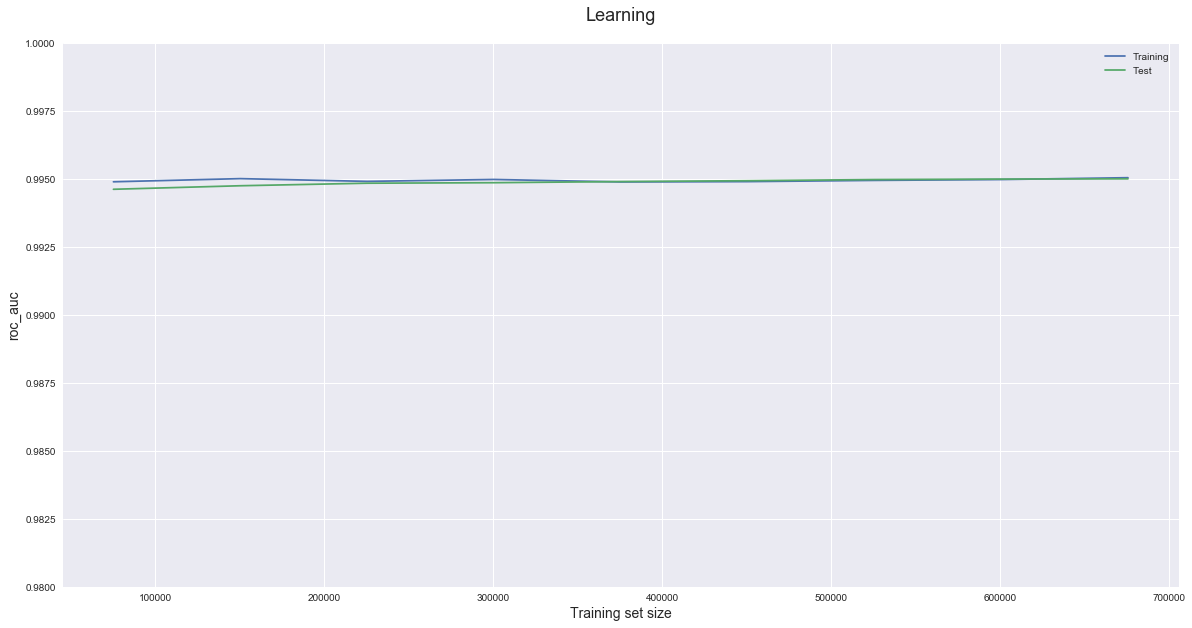

In [296]:
train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, test_scores_mean, label = 'Test')
plt.ylabel('roc_auc', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.98,1)


In [297]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(),
                                                        X = X_train_scale,
                                                        y = y_train,
                                                        train_sizes = train_size, 
                                                        cv = 5,
                                                        scoring = 'f1',
                                                        n_jobs= -1)


print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', test_scores)


Training scores:

 [[0.97026333 0.96879899 0.96879899 0.96879899 0.96879899]
 [0.97199969 0.9708711  0.9708711  0.9708711  0.9708711 ]
 [0.97247988 0.97186037 0.97207402 0.97207402 0.97207402]
 [0.97331339 0.97294188 0.97264037 0.97264037 0.97264037]
 [0.97359611 0.97322157 0.97304916 0.97305083 0.97305083]
 [0.9737931  0.97346254 0.97327552 0.97354751 0.97354751]
 [0.97393909 0.97366382 0.97349967 0.97367603 0.97367603]
 [0.97406431 0.97381111 0.97365658 0.97382159 0.97387321]
 [0.97438463 0.97415796 0.9740015  0.97417873 0.97410321]]

 ----------------------------------------------------------------------

Validation scores:

 [[0.96985593 0.96982005 0.97045032 0.96993194 0.97001772]
 [0.97165176 0.97162851 0.97222836 0.97170147 0.97170495]
 [0.97217041 0.97243993 0.97277802 0.97225561 0.97248381]
 [0.97271044 0.97292591 0.97320629 0.97275893 0.97322665]
 [0.97292791 0.97328104 0.9736084  0.97311143 0.9736278 ]
 [0.97314523 0.97348169 0.97389834 0.97338496 0.97380057]
 [0.97331144 0.

(0.98, 1)

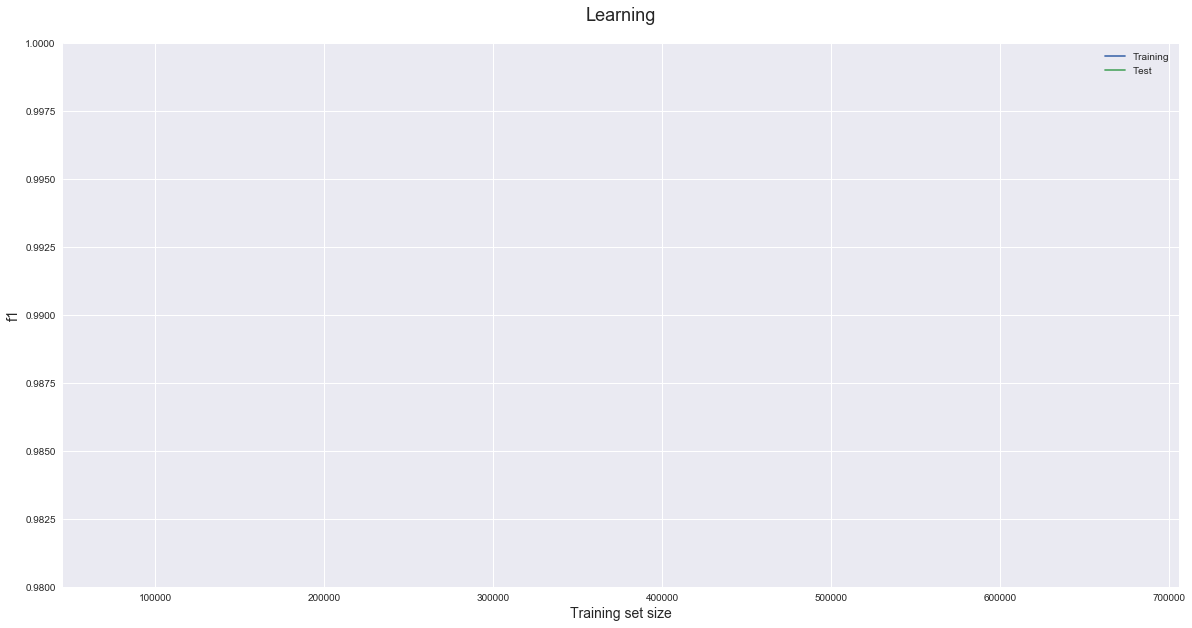

In [298]:
train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1)

plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, test_scores_mean, label = 'Test')
plt.ylabel('f1', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.98,1)


# Regularization

In [100]:
#list(np.power(10.0, np.arange(-10, 10)))

In [299]:
C_param_range = [0.05, 0.1, 1, 1.5, 2]

In [300]:
lr = LogisticRegression(penalty='l2', random_state = 0)

In [301]:
train_scores, test_scores = validation_curve(estimator=lr,
                                             X=X_train_scale,
                                             y=y_train,
                                             param_name='C',
                                             param_range=C_param_range,
                                             cv=5,
                                             scoring="roc_auc",
                                             n_jobs=-1)


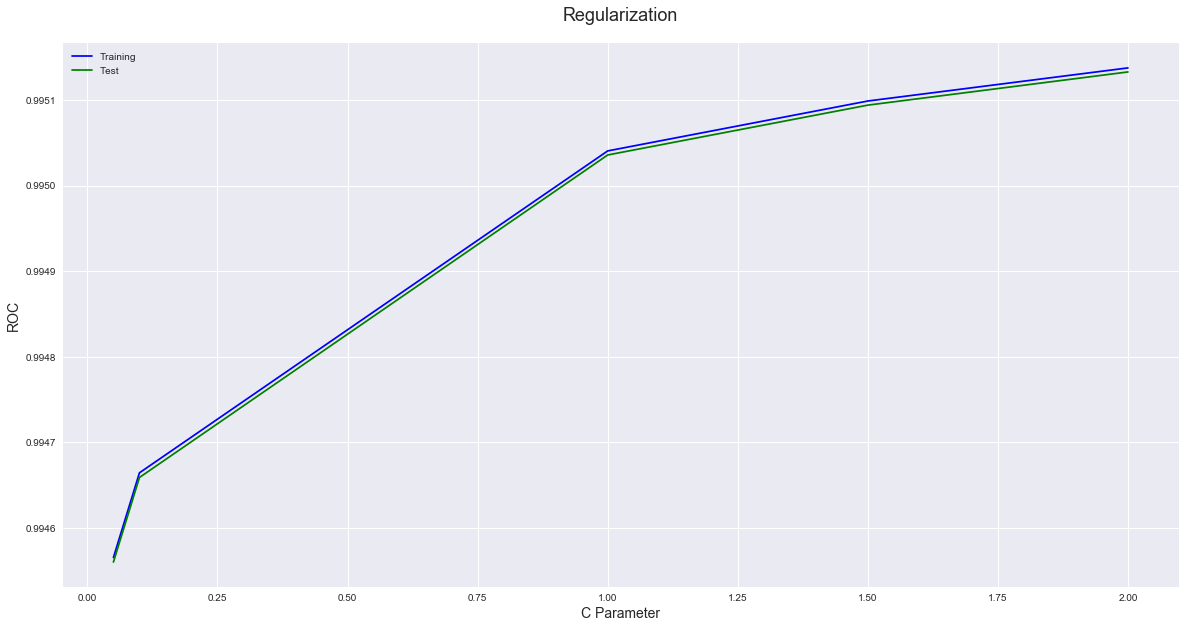

In [302]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.plot(C_param_range, train_mean, color='blue', label='Training')
plt.plot(C_param_range, test_mean, color='green', label='Test')
plt.ylabel('ROC', fontsize = 14)
plt.xlabel('C Parameter', fontsize = 14)
plt.title('Regularization', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0.8,1)
plt.show()




# 1st Conclusion

Tasks done:
1. Picked variables on Mutual Information
2. Picked variables left with forward search algorithm
3. Logistic Regression model
4. Logistic Regression with regularization (validation curve)

Conclusion:
1. Picking up right variables increased accuracy, precision , and recall
2. Learning Curve shows convergence
3. Validation curve shows no variance bias

# SVM

# Rules of Thumb
n = number of features <br>
m = number of observations<br>
1. n is large relative to m: use linear svm
2. n is small relative to m: use gausian svm
3. n is much smaller than m: use linear svm (also add features if possible)


In [125]:
# linear kernel
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train_scale, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [126]:
y_pred = svclassifier.predict(X_test)


In [131]:
metrics.confusion_matrix(y_test, y_pred)

array([[312995,    142],
       [  3845,  85309]])

In [134]:
print("F1: " + str(metrics.f1_score(y_train, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_test, y_pred)))
print("Precision: " + str(metrics.precision_score(y_test, y_pred)))
print("Recall: " + str(metrics.recall_score(y_test, y_pred)))

Accuracy: 0.9900892637419182
Precision: 0.9983382289265192
Recall: 0.9568723781322207


# Random Forest

In [ ]:
clf=RandomForestClassifier(n_estimators=100)


In [ ]:
clf.fit(X_train, y_train)


In [ ]:
predictions = clf.predict(X_test)

In [ ]:
metrics.confusion_matrix(y_test, predictions)


### Consider
n_estimators = number of trees in the foreset <br>
max_features = max number of features considered for splitting a node<br>
max_depth = max number of levels in each decision tree<br>
min_samples_split = min number of data points placed in a node before the node is split<br>
min_samples_leaf = min number of data points allowed in a leaf node<br>
bootstrap = method for sampling data points (with or without replacement)<br>


In [ ]:
svm_col = x_train.columns[k_best_features.get_support()]
svm_col = svm_col[0:20]
X_scale = X[svm_col]
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size = 0.80)


In [ ]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [0.05, 0.1, 0.15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [0.001, 0.0001,0.01, 0.004]
# Method of selecting samples for training each tree
bootstrap = [True, False]


In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [ ]:
rf = RandomForestClassifier(n_estimators=100)


In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, 
                               n_jobs=-1, return_train_score=True)


In [ ]:
X_train.shape

In [ ]:
rf_random.fit(X_train, y_train);


In [ ]:
rf_random.best_params_


In [ ]:
clf=RandomForestClassifier(n_estimators = 300,
                           max_features = 'log2',
                           max_depth = 50,
                           min_samples_split = 0.05,
                           min_samples_leaf = 0.001,
                           bootstrap= False)

In [ ]:
clf.fit(X_train, y_train)


In [ ]:
predictions = clf.predict(X_test)
metrics.confusion_matrix(y_test, predictions)


In [170]:
rf_random.cv_results_


{'mean_fit_time': array([ 32.98019338, 154.3762579 , 139.85794648,  94.98654048,
         72.96919203,  56.20011298, 216.4041357 , 104.87715308,
         99.39741524,  73.83505694,  36.36487738, 254.06643764,
        100.53091272, 154.51166153,  78.19716295, 155.27521729,
         48.31709607,  62.7357587 , 156.07490365, 220.57057556,
        167.23535601, 217.34587963,  40.88605769, 181.83446916,
         61.11850007,  76.86172978,  68.72640077, 130.39366992,
         31.23832329, 162.2705512 , 176.71290676, 186.76975679,
         73.2292974 ,  55.45762626,  51.06478945, 203.36302988,
         81.7672863 ,  99.30898174,  64.16728671, 165.95502265,
         36.24921012,  35.53760107,  96.52234689, 172.21600668,
        247.98088392, 126.63427003, 150.3806754 , 167.28696926,
        127.60603174, 204.5676566 , 135.22532002, 119.99040858,
        141.82827385, 116.70062677, 201.8100601 , 110.29096691,
         37.30335959, 124.67436997, 294.52969305, 154.66346407,
         32.91133952, 1

In [188]:
len(data)

1340968